## Fit data using GLLS in SAMMY

This notebook works to shows how the sammy interface module of ATARI can be used to fit data with SAMMY

In [1]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
from dataclasses import asdict
from copy import copy

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.theory.resonance_statistics import make_res_par_avg
from ATARI.sammy_interface import sammy_classes, sammy_functions
import ATARI.utils.io.hdf5 as h5io 
import importlib


In [2]:
%matplotlib widget

# First, setup/generate synthetic data using SAMMY

#### Define physical values, experiment, and resonance ladder

In [3]:
ac = 0.81271  # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider

Elam = 50.0
E_min_max = [np.max([Elam-20, 1.0]), Elam+20]
energy_grid = np.linspace(min(E_min_max), max(E_min_max), 1000)

# for Gg_DOF in [10,50,100,1000,10000]:
Gg_DOF = 10

from ATARI.theory import scattering_params
shift, penetration, phi, k = scattering_params.FofE_explicit([1,500], ac, M, m, 0)
res_par_avg = make_res_par_avg(D_avg = 8.79, 
                            Gn_avg= np.mean(penetration)*2*46.4, #0.658, 
                            n_dof = 1, 
                            Gg_avg = 64.0, 
                            g_dof = Gg_DOF, 
                            print = False)


spin_groups = [ (3.0,1,0) ]
average_parameters = {'3.0':res_par_avg}

Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups,
                                average_parameters=average_parameters )   
# resonance_ladder = Ta_pair.sample_resonance_ladder(energy_grid, spin_groups, average_parameters)
resonance_ladder = pd.DataFrame({"E":[31.8030900, 43.3031830, 56.0645210],
                                 "Gg":[54.9451300, 59.7455500, 86.1347900],
                                 "Gn1":[0.3913400, 2.9012500, 2.1717400],
                                 "J":[ 3,3,3,], "chs":[1,1,1,], "lwave":[0,0,0], "J_ID":[1,1,1]})
# resonance_ladder = pd.DataFrame({'E':[80.0], 'Gt':[16], 'Gn':[1], 'J':[3], 'chs':[1], 'lwave':[0], 'J_ID':[1]})
# resonance_ladder = pd.DataFrame({'E':[4.0], 'Gg':[7.0], 'Gn':[4.0], 'J':[3], 'chs':[1], 'lwave':[0], 'J_ID':[1]})
resonance_ladder

,E,Gg,Gn1,J,chs,lwave,J_ID
0,31.803090,54.94513,0.39134,3,1,0,1
1,43.303183,59.74555,2.90125,3,1,0,1
2,56.064521,86.13479,2.17174,3,1,0,1


In [4]:
importlib.reload(sammy_classes)
importlib.reload(sammy_functions)

sammyRTO = sammy_classes.SammyRunTimeOptions(
    path_to_SAMMY_exe = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
    model = 'SLBW',
    reaction = 'total',
    solve_bayes = False,
    inptemplate = "/Users/noahwalton/Documents/GitHub/ATARI/examples/sammy_template.inp", #"allexptot_1sg.inp",
    inpname = "sammy.inp",
    energy_window = None,
    sammy_runDIR = 'SAMMY_runDIR',
    keep_runDIR = False,
    shell = 'zsh'
    )

sammyINP = sammy_classes.SammyInputData(
    particle_pair = Ta_pair,
    resonance_ladder = resonance_ladder,
    energy_grid = energy_grid,
    temp = 304.5,
    FP=35.185,
    frac_res_FP=0.049600,
    target_thickness=0.067166)

sammyOUT = sammy_functions.run_sammy(sammyINP, sammyRTO)

unc_scale = 0.05
trans = pd.DataFrame({'E': energy_grid})
# trans["exp"] = sammyOUT.pw["theo_trans"] #np.random.default_rng().normal(sammyOUT.pw["theo_trans"], np.sqrt(sammyOUT.pw["theo_trans"])*unc_scale )
trans["exp"] = abs(np.random.default_rng().normal(sammyOUT.pw["theo_trans"], np.sqrt(sammyOUT.pw["theo_trans"])*unc_scale ))
trans["exp_unc"] = np.sqrt(trans["exp"])*unc_scale

estladder = copy(resonance_ladder)
estladder[["Gg", "Gn1"]] = estladder[["Gg", "Gn1"]]*0.1
# estladder["E"] = estladder["E"] + 10

sammyRTO.solve_bayes = True
sammyRTO.reaction = 'transmission'
sammyRTO.keep_runDIR = True
sammyRTO.recursive = False
sammyRTO.recursive_opt = {"threshold":0.01,
                            "iterations": 20,
                            "print":True}

sammyINP.experimental_data = trans
sammyINP.resonance_ladder = estladder
sammyINP.initial_parameter_uncertainty = 0.1

sammyOUT_fit = sammy_functions.run_sammy(sammyINP, sammyRTO)


In [5]:
print(sammyOUT_fit.par)
print(sammyOUT_fit.par_post)
print(resonance_ladder)

           E        Gg       Gn1  J  chs  lwave  J_ID
0  31.803090  5.494513  0.039134  3    1      0     1
1  43.303183  5.974555  0.290125  3    1      0     1
2  56.064521  8.613479  0.217174  3    1      0     1
           E          Gg       Gn1  varyE  varyGg  varyGn1  J_ID
0  31.799534    6.208010  0.227735    1.0     1.0      1.0   1.0
1  43.323384  435.969684  0.839240    1.0     1.0      1.0   1.0
2  56.046378  191.317085  0.845469    1.0     1.0      1.0   1.0
           E        Gg      Gn1  J  chs  lwave  J_ID
0  31.803090  54.94513  0.39134  3    1      0     1
1  43.303183  59.74555  2.90125  3    1      0     1
2  56.064521  86.13479  2.17174  3    1      0     1


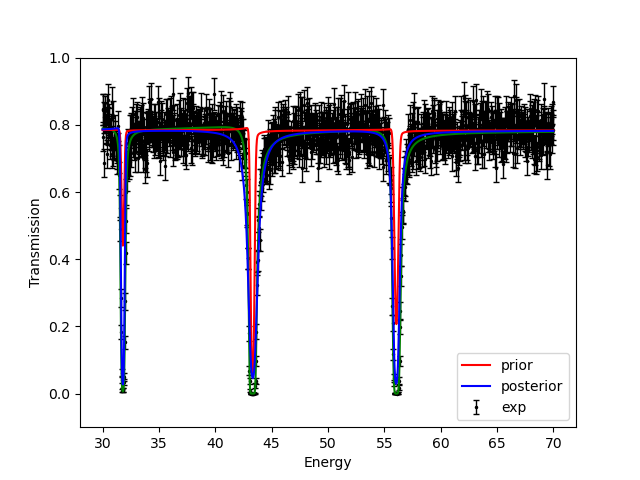

In [6]:
figure()
plot(sammyOUT.pw.E, sammyOUT.pw.theo_trans, 'g')
plot(sammyOUT_fit.pw.E, sammyOUT_fit.pw.theo_trans, ms=1, color='r', label='prior')
plot(sammyOUT_fit.pw.E, sammyOUT_fit.pw.theo_trans_bayes, ms=1, color='b', label='posterior')
errorbar(trans.E, trans.exp, yerr=trans.exp_unc, zorder=0, 
                                        fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')

ylim([-.1, 1])
# xscale('log')
xlabel('Energy'); ylabel('Transmission')
legend()


#### Method for doing least squares with sammy

This iterative approach uses bash shell scripting. To run this on your machine, it is important that you have:
bc 4.0.2 from Copyright (c) 2018-2021 Gavin D. Howard and https://git.yzena.com/gavin/bc

This is standard for macos zsh
The standard bash shell on the utk linux cluster comes with GNU bc which will NOT work. If running on the cluster, download and install the above bc package and make sure that your local shell will see this software as 'bc' before the default GNU bc.

In [16]:
case_file = '/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/data.hdf5'  # if using hdf5

isample = 2

dataset_titles = ["trans1", "cap1"]
datasets = []
for dt in dataset_titles:
    exp_pw, exp_cov = h5io.read_pw_exp(case_file, isample, title=dt)
    datasets.append(exp_pw)

theo_par = h5io.read_par(case_file, isample, 'true')  #for fine grid theoretical

trans = datasets[0]
cap = datasets[1]
theo_par[["varyE","varyGg", "varyGn1"]] = np.ones((len(theo_par), 3))
theo_par

,E,Gg,Gn1,J,chs,lwave,J_ID,varyE,varyGg,varyGn1
0,76.498888,90.575820,0.006013,3.0,1.0,0.0,1.0,1.0,1.0,1.0
1,77.298352,43.496794,0.826750,3.0,1.0,0.0,1.0,1.0,1.0,1.0
2,99.017765,52.065973,7.125839,3.0,1.0,0.0,1.0,1.0,1.0,1.0
3,103.039226,47.421448,0.193376,3.0,1.0,0.0,1.0,1.0,1.0,1.0
4,106.696854,75.531884,2.533601,3.0,1.0,0.0,1.0,1.0,1.0,1.0
5,115.032975,51.465981,2.185579,3.0,1.0,0.0,1.0,1.0,1.0,1.0


In [17]:

# sammyRTO_ls.sammy_runDIR = "./SAMMY_runDIR_ls"
sammyRTO.keep_runDIR = True
iterations = 2
steps = 200
threshold = 0.01

reactions = ["transmission", "capture"]
templates = ["allexptot_1sg.inp", "allexpcap_1sg.inp"]


sammyRTO = sammy_classes.SammyRunTimeOptions(
    path_to_SAMMY_exe = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
    sammy_runDIR = 'SAMMY_runDIR_totcapsim',
    keep_runDIR = True,
    shell = 'zsh',

    model = 'XCT',
    reaction = 'total',
    solve_bayes = False
    )

sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = theo_par,

    datasets= datasets,
    dataset_titles= dataset_titles,
    reactions= reactions,
    templates= templates,
    
    steps = 200,
    iterations = 2,
    step_threshold = 0.01,
    autoelim_threshold = None,

    LS = False,
    initial_parameter_uncertainty = 0.01,

    temp = 304.5,
    FP=35.185,
    frac_res_FP=0.049600,
    target_thickness=0.067166)


par, lsts = sammy_functions.run_sammy_YW(sammyINPyw, sammyRTO)


rm: chi2.txt: No such file or directory
